# 01. Finetuning OPT with LoRA

Today's popular auto-regressive models - such as, GPT, LLaMA, Falcon, etc - are decoder-only models, in which the output token is predicted by using only input's text (called a prompt).

*"Decoder-only" model is implemented using layers in the red box.<br>
(Diagram from : [Attention Is All You Need](https://arxiv.org/abs/1706.03762))*

In this model, the task is differentiated also by using input's text (i.e, prompt).

In this example, we fine-tune the pre-trained auto-regressive model, Meta's OPT (```facebook/opt-125m```), by applying LoRA (Low-Rank Adaptation) optimization.

In this example, I download the pre-trained model from Hugging Face hub, but fine-tune model with regular PyTorch training loop.<br>
(Here I don't use Hugging Face Trainer class.)

See [Readme](https://github.com/tsmatz/finetune_llm_with_lora) for prerequisite's setup.

In [1]:
import torch

device = torch.device("cuda")

model_name = "facebook/opt-125m"

## Prepare dataset and dataloader
I used [dataset](https://github.com/microsoft/LoRA) from the Microsoft's repository.

In [2]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt

--2025-12-10 20:33:49--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/train.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt [following]
--2025-12-10 20:33:50--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9624463 (9.2M) [text/plain]
Saving to: ‘train.txt.2’

train.txt.2         100%[===================>]   9.18M  --.-KB/s    in 0.09s   

2025-12-10 20:33:50 (101 MB/s) - ‘train.txt.2’ saved [9624463/9624463]



In [3]:
!wget https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt

--2025-12-10 20:33:50--  https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt [following]
--2025-12-10 20:33:51--  https://raw.githubusercontent.com/microsoft/LoRA/main/examples/NLG/data/e2e/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1351149 (1.3M) [text/plain]
Saving to: ‘test.txt.2’

test.txt.2          100%[===================>]   1.29M  --.-KB/s    in 0.05s   

2025-12-10 20:33:51 (24.0 MB/s) - ‘test.txt.2’ saved [1351149/1351149]



The first 5 rows of the dataset.

In [4]:
!head -n 5 train.txt

name : The Vaults | Type : pub | price : more than £ 30 | customer rating : 5 out of 5 | near : Café Adriatic||The Vaults pub near Café Adriatic has a 5 star rating . Prices start at £ 30 . 
name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Café Brazil||Close to Café Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of £ 10.50 . Delicious Pub food . 
name : The Eagle | Type : coffee shop | food : Japanese | price : less than £ 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King||The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £ 20 for Japanese food . 
name : The Mill | Type : coffee shop | food : French | price : £ 20 - 25 | area : riverside | near : The Sorrento||Located near The Sorrento is a French Theme eatery and coffee shop called The Mill , with a price range at £ 20- £ 25 it is in the riverside area . 
name : Loch 

Converting the data into JsonL format.

In [5]:
import sys
import io
import json

def format_convert(read_file, write_file):
    with open(read_file, "r", encoding="utf8") as reader, \
    	 open(write_file, "w", encoding="utf8") as writer :
    	for line in reader:
    		items = line.strip().split("||")
    		context = items[0]
    		completion = items[1].strip("\n")
    		x = {}
    		x["context"] = context
    		x["completion"] = completion
    		writer.write(json.dumps(x)+"\n")

format_convert("train.txt", "train_formatted.jsonl")
format_convert("test.txt", "test_formatted.jsonl")

The first 5 rows of the dataset.

In [6]:
with open("train_formatted.jsonl", "r") as reader:
    for _ in range(5):
        print(next(reader))

{"context": "name : The Vaults | Type : pub | price : more than \u00a3 30 | customer rating : 5 out of 5 | near : Caf\u00e9 Adriatic", "completion": "The Vaults pub near Caf\u00e9 Adriatic has a 5 star rating . Prices start at \u00a3 30 ."}

{"context": "name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Caf\u00e9 Brazil", "completion": "Close to Caf\u00e9 Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of \u00a3 10.50 . Delicious Pub food ."}

{"context": "name : The Eagle | Type : coffee shop | food : Japanese | price : less than \u00a3 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King", "completion": "The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than \u00a3 20 for Japanese food ."}

{"context": "name : The Mill | Type : coffee shop | food : French | price : \u00a3 20 - 25 | area : riverside | near : The Sorrento", "com

Load tokenizer from Hugging Face.

In [7]:
from transformers import AutoTokenizer
import os

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    fast_tokenizer=True)
tokenizer.pad_token = tokenizer.eos_token
os.environ["TOKENIZERS_PARALLELISM"] = "false"

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Set block size, which is used to separate long text for model consumption.

In [8]:
block_size = 512

We now implement a function to convert raw text examples into training-ready tensors. For each sample, the function performs the following steps:

1. Tokenization: Both the context (prompt) and completion (target response) are separately tokenized using the GPT-2 tokenizer. Example: "This is a pen." → [1212, 318, 257, 3112, 13]
2. Concatenation with Separator: The tokenized context and completion are joined into a single sequence, separated by a newline token (\n). This combined sequence serves as the model’s input.
3. Label Creation (Causal Language Modeling): Labels are created by right-shifting the input sequence by one position (input_ids[1:]). All positions corresponding to the original context (prompt) are set to -100 so that the loss is computed only on the completion tokens.
4. Padding to Fixed Length: Both input_ids and labels are padded (or truncated) to exactly block_size (the model’s maximum context length).

In [9]:
from torch.utils.data import DataLoader
import pandas as pd

def fill_ignore_label(l, c):
    l[:len(c) - 1] = [-100] * (len(c) - 1)
    return l

def pad_tokens(tokens, max_seq_length, padding_token):
    res_tokens = tokens[:max_seq_length]
    token_len = len(res_tokens)
    res_tokens = res_tokens + \
        [padding_token for _ in range(max_seq_length - token_len)]
    return res_tokens

def collate_batch(batch):
    # tokenize both context and completion respectively
    # (context and completion is delimited by "\n")
    context_list = list(zip(*batch))[0]
    context_list = [c + "\n" for c in context_list]
    completion_list = list(zip(*batch))[1]
    context_result = tokenizer(context_list)
    context_tokens = context_result["input_ids"]
    context_masks = context_result["attention_mask"]
    completion_result = tokenizer(completion_list)
    completion_tokens = completion_result["input_ids"]
    completion_masks = completion_result["attention_mask"]
    # OPT tokenizer adds the start token in sequence,
    # and we then remove it in completion
    completion_tokens = [t[1:] for t in completion_tokens]
    completion_masks = [t[1:] for t in completion_masks]
    # concatenate token
    inputs = [i + j for i, j in zip(context_tokens, completion_tokens)]
    masks = [i + j for i, j in zip(context_masks, completion_masks)]
    # create label
    eos_id = tokenizer.encode(tokenizer.eos_token)[0]
    labels = [t[1:] + [eos_id] for t in inputs]
    labels = list(map(fill_ignore_label, labels, context_tokens))
    # truncate and pad tokens
    inputs = [pad_tokens(t, block_size, 0) for t in inputs] # OPT and GPT-2 doesn't use pad token (instead attn mask is used)
    masks = [pad_tokens(t, block_size, 0) for t in masks]
    labels = [pad_tokens(t, block_size, -100) for t in labels]
    # convert to tensor
    inputs = torch.tensor(inputs, dtype=torch.int64).to(device)
    masks = torch.tensor(masks, dtype=torch.int64).to(device)
    labels = torch.tensor(labels, dtype=torch.int64).to(device)
    return inputs, labels, masks

Now create PyTorch dataloader with previous function (collator function).

In [10]:
batch_size = 8
gradient_accumulation_steps = 16

data = pd.read_json("train_formatted.jsonl", lines=True)
dataloader = DataLoader(
    list(zip(data["context"], data["completion"])),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

## Load model
Load model from Hugging Face.

In [11]:
from transformers import AutoModelForCausalLM, AutoConfig

config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
).to(device)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

## Generate Text Before Fine-Tuning
Now, trying some prediction with downloaded model which is not still fine-tuned.

First we create a function to generate text.

> Note : In order to speed up, use **attention cache** for sequential token generation in production.<br>
> (In this example, all outputs in the sequence are re-computed without caching every time.)

In [12]:
def generate_text(model, input, mask, eos_id, pred_sequence_length):
    predicted_last_id = -1
    start_token_len = torch.sum(mask).cpu().numpy()
    token_len = start_token_len
    with torch.no_grad():
        while (predicted_last_id != eos_id) and \
              (token_len - start_token_len < pred_sequence_length):
            output = model(
                input_ids=input,
                attention_mask=mask,
            )
            predicted_ids = torch.argmax(output.logits, axis=-1).cpu().numpy()
            predicted_last_id = predicted_ids[0][token_len - 1]
            input[0][token_len] = predicted_last_id
            mask[0][token_len] = 1
            token_len = torch.sum(mask).cpu().numpy()
    return input, token_len

Testing the function to generate text.

Here, I stoped the text generation when it reaches 15 tokens in prediction.

In [13]:
eos_id = tokenizer.encode(tokenizer.eos_token)[0]

result = tokenizer("Once upon a time,")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

result = tokenizer("My name is Laura and I am")
input = result["input_ids"]
mask = result["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype=torch.int64).to(device)
mask = torch.tensor([mask], dtype=torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input,
    mask,
    eos_id,
    pred_sequence_length=15)
print(tokenizer.decode(result_token[0][:result_len]))

</s>Once upon a time, I was a student at the University of California, Berkeley. I was a
</s>My name is Laura and I am a single mom of two. I am a single mom of two. I


Now, generating text with our test dataset.

As you can see below, it cannot output the completion well, because it's not still fine-tuned.

In [14]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("---------- INPUT ----------")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("---------- RESULT ----------")
    print(tokenizer.decode(result_token[0][:result_len]))

---------- INPUT ----------
</s>name : The Mill | Type : restaurant | food : English | price : moderate | customer rating : 3 out of 5 | area : riverside | family friendly : no | near : Café Rouge

---------- RESULT ----------
</s>name : The Mill | Type : restaurant | food : English | price : moderate | customer rating : 3 out of 5 | area : riverside | family friendly : no | near : Café Rouge

The Mill is a restaurant located in the heart of the River Rouge neighborhood of River Rouge, Louisiana. The restaurant is open from 10am to 5
---------- INPUT ----------
</s>name : The Wrestlers | Type : restaurant | food : Japanese | price : moderate | area : riverside | family friendly : yes | near : Raja Indian Cuisine

---------- RESULT ----------
</s>name : The Wrestlers | Type : restaurant | food : Japanese | price : moderate | area : riverside | family friendly : yes | near : Raja Indian Cuisine

The Wrestlers is a Japanese restaurant located in the city of Nagoya, Japan. It is a popular 

## LoRA (Low-Rank Adaptation)

It's time to apply LoRA in our downloaded model.

I manually transformed the pre-trained GPT-2 model to support LoRA, giving us full control and deeper insight into the adaptation process.

Understanding GPT-2’s Architecture

[LoRA](https://arxiv.org/abs/2106.09685) is developed by Microsoft Research and it's a popular adaptation method for efficient fine-tuning.

In a task-specific fine-tuning, the change in weights during model adaptation has a low intrinsic rank.<br>
With this hypothesis, we can assume that model's updates ($ \Delta W $) will be re-written with much smaller low-rank matrices $ B \cdot A $ as follows.

$$ \displaystyle W_0 x + \Delta W x = W_0 x + B \cdot A x $$

where

- $ W_0 \in \mathbb{R}^{d \times k} $ is a pre-trained weight's matrix (which is frozen).
- $ \Delta W $ is updates.
- $ B \in \mathbb{R}^{d \times r}, A \in \mathbb{R}^{r \times k} $ and $ \verb| rank |\ r \ll min(d, k) $


*From : [LoRA fine-tuning](https://martinlwx.github.io/en/lora-finetuning/)*

In this assumption, we freeze all weights except for $ B $ and $ A $, and train only these low-ranked matrices $ B $ and $ A $.<br>
With this manner, you can fine-tune large transformers for a specific task without full-parameter's fine-tuning.

This will significantly save the required capacity (GPU memories) for training, and the number of required GPUs can approximately be reduced to one-fourth in the benchmark with GPT-3.

Before modifying the model, let’s first examine its architecture.
When we print the OPT model (as shown in the output cell), we can see that each transformer block contains six standard linear layers (```torch.nn.Linear```):

- One for the query projection
- One for the key projection
- One for the value projection
- One for the attention output projection (out_proj)
- Two in the feed-forward network (fc1 and fc2)

That’s a total of 6 linear layers per transformer block.
The original LoRA paper recommends applying low-rank adaptation only to the query and value projections (i.e., just 2 out of the 6 layers per block).
In this project, however, we will go beyond the original paper and apply LoRA to all six linear layers in every transformer block — this is a common and effective practice in many real-world fine-tuning setups.
Since OPT-125M has 12 transformer layers, this results in a total of 6 × 12 = 72 linear layers that we will convert into LoRA-augmented versions.

In [15]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

First we build custom linear layer with LoRA as follows.

In [16]:
import math
from torch import nn

class LoRA_Linear(nn.Module):
    def __init__(self, weight, bias, lora_dim):
        super().__init__()

        row, column = weight.shape

        # restore Linear
        if bias is None:
            self.linear = nn.Linear(column, row, bias=False)
            self.linear.load_state_dict({"weight": weight})
        else:
            self.linear = nn.Linear(column, row)
            self.linear.load_state_dict({"weight": weight, "bias": bias})

        # create LoRA weights (with initialization)
        self.lora_right = nn.Parameter(torch.zeros(column, lora_dim))
        nn.init.kaiming_uniform_(self.lora_right, a=math.sqrt(5))
        self.lora_left = nn.Parameter(torch.zeros(lora_dim, row))

    def forward(self, input):
        x = self.linear(input)
        y = input @ self.lora_right @ self.lora_left
        return x + y

Replace targeting linear layers with LoRA layers.

In [17]:
lora_dim = 4

# get target module name
target_names = []
for name, module in model.named_modules():
    if isinstance(module, nn.Linear) and "decoder.layers." in name:
        target_names.append(name)

# replace each module with LoRA
for name in target_names:
    name_struct = name.split(".")
    # get target module
    module_list = [model]
    for struct in name_struct:
        module_list.append(getattr(module_list[-1], struct))
    # build LoRA
    lora = LoRA_Linear(
        weight = module_list[-1].weight,
        bias = module_list[-1].bias,
        lora_dim = lora_dim,
    ).to(device)
    # replace
    module_list[-2].__setattr__(name_struct[-1], lora)

Lets check how model changed.

In [18]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): LoRA_Linear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
            )
            (v_proj): LoRA_Linear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
            )
            (q_proj): LoRA_Linear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
            )
            (out_proj): LoRA_Linear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
            )
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_a

Finally, freeze all parameters except for LoRA parameters.

In [19]:
for name, param in model.named_parameters():
    if "lora_right" in name or "lora_left" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [20]:
### Do this when you run adapter fine-tuning on Hugging Face framework
# model.gradient_checkpointing_enable()
# model.enable_input_require_grads()

## Fine-tune
Now, let's start to run fine-tuning.

First we build optimizer as follows.

In [21]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.95),
)

In this example, we build cosine scheduler for training.

In [22]:
from torch.optim.lr_scheduler import LambdaLR

num_epochs = 2

num_update_steps = math.ceil(len(dataloader) / gradient_accumulation_steps)
def _get_cosine_schedule(
    current_step: int,
    num_warmup_steps: int = 0,
    num_training_steps: int = num_epochs * num_update_steps
):
    if current_step < num_warmup_steps:
        return 1.0
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
scheduler = LambdaLR(optimizer, lr_lambda=_get_cosine_schedule)

Run fine-tuning.

In [23]:
from torch.nn import functional as F

if os.path.exists("loss.txt"):
    os.remove("loss.txt")

for epoch in range(num_epochs):
    optimizer.zero_grad()
    model.train()
    for i, (inputs, labels, masks) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            outputs = model(
                input_ids=inputs,
                attention_mask=masks,
            )
            loss = F.cross_entropy(outputs.logits.transpose(1,2), labels)
            loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

            print(f"Epoch {epoch+1} {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_update_steps} - loss: {loss.item() :2.4f}", end="\r")

        # record loss
        with open("loss.txt", "a") as f:
            f.write(str(loss.item()))
            f.write("\n")
    print("")

# save model
torch.save(model.state_dict(), "finetuned_opt.bin")

Epoch 1 329/329 - loss: 1.8738
Epoch 2 329/329 - loss: 0.8907


> Note : Here we save LoRA-enabled model without any changes, but you can also merge the trained LoRA's parameters into the original linear layer's weights.

Plotting loss transition.

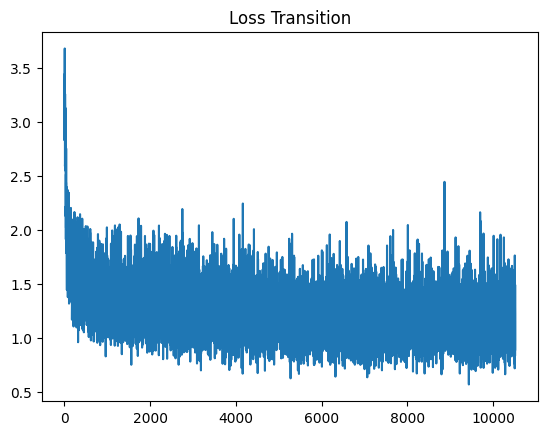

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("loss.txt")
plt.plot(data)
plt.title("Loss Transition")
plt.show()

## Generate Text with Fine-Tuned Model

Again we check results with our test dataset (5 rows).<br>
As you can see below, it can output the completion very well, because it's fine-tuned.

In [25]:
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2]  # because it's duplicated
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i, (input, _, mask) in enumerate(test_loader):
    if i == 5:
        break
    print("---------- INPUT ----------")
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input,
        mask,
        eos_id,
        pred_sequence_length=30)
    print("---------- RESULT ----------")
    print(tokenizer.decode(result_token[0][:result_len]))

---------- INPUT ----------
</s>name : The Phoenix | Type : pub | food : French | price : £ 20 - 25 | customer rating : high | area : city centre | family friendly : yes | near : Crowne Plaza Hotel

---------- RESULT ----------
</s>name : The Phoenix | Type : pub | food : French | price : £ 20 - 25 | customer rating : high | area : city centre | family friendly : yes | near : Crowne Plaza Hotel
The Phoenix is a pub that serves French food in the city centre near Crowne Plaza Hotel . It is kid friendly and has a high customer rating .
---------- INPUT ----------
</s>name : The Cricketers | Type : restaurant | food : Chinese | price : cheap | customer rating : 5 out of 5 | area : city centre | family friendly : no | near : All Bar One

---------- RESULT ----------
</s>name : The Cricketers | Type : restaurant | food : Chinese | price : cheap | customer rating : 5 out of 5 | area : city centre | family friendly : no | near : All Bar One
The Cricketers is a Chinese restaurant with a custom

In [26]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

663552

In [27]:
# Install required packages (run once)
!pip install sacrebleu rouge-score matplotlib seaborn pandas
!git clone https://github.com/tuetschek/e2e-metrics.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00
Cloning into 'e2e-metrics'...
remote: Enumerating objects: 909, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 909 (delta 0), reused 0 (delta 0), pack-reused 907 (from 2)
Receiving objects: 100% (909/909), 106.78 MiB | 43.75 MiB/s, done.
Resolving deltas: 100% (492/492), done.


In [28]:
import torch
import json
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

sns.set(style="whitegrid", font_scale=1.3, rc={"figure.figsize": (10, 6)})

# Load test data
test_data = pd.read_json("test_formatted.jsonl", lines=True)
test_data = test_data[::2].reset_index(drop=True)  # remove duplicates

# Helper: generate text using your trained model (same as in notebook)
def generate(model, tokenizer, context, max_new_tokens=50):
    model.eval()
    inputs = tokenizer(context + "\n", return_tensors="pt").to(device)
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    
    generated = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(generated[0], skip_special_tokens=True).split("\n")[-1].strip()

# Generate predictions
references = []
hypotheses = []

print("Generating predictions on test set...")
for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
    pred = generate(model, tokenizer, row["context"])
    hypotheses.append(pred)
    references.append(row["completion"])

# Save for official E2E metric script
with open("hyp.txt", "w") as f:
    for h in hypotheses:
        f.write(h + "\n")

with open("ref.txt", "w") as f:
    for r in references:
        f.write(r + "\n")

Generating predictions on test set...


100%|██████████| 2347/2347 [15:01<00:00,  2.60it/s]


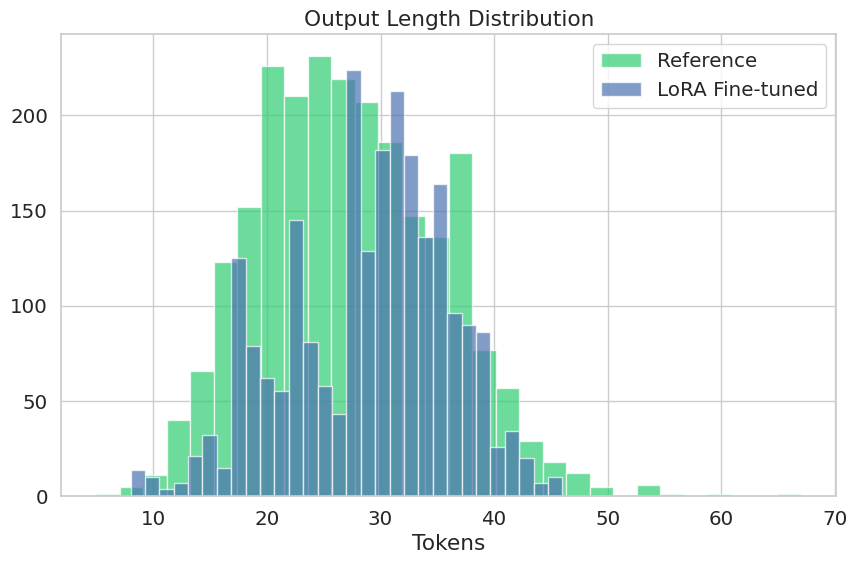

In [29]:
lens_ref = [len(r.split()) for r in references]
lens_hyp = [len(h.split()) for h in hypotheses]

plt.hist(lens_ref, alpha=0.7, bins=30, label="Reference", color="#2ecc71")
plt.hist(lens_hyp, alpha=0.7, bins=30, label="LoRA Fine-tuned")
plt.legend()
plt.title("Output Length Distribution")
plt.xlabel("Tokens")
plt.show()